In [1]:
!nvidia-smi

Wed May  4 03:59:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!cp "./drive/MyDrive/zerowaste-f-final.zip" ./
!unzip "./zerowaste-f-final.zip"

Streaming output truncated to the last 5000 lines.
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005690.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005700.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005710.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005720.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005730.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005740.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005750.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005760.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005770.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005780.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005790.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005800.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005810.PNG  
  inflating: 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ----- #
# Install detectron2
# ----- #
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version
# opencv is pre-installed on colab
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 62.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 10.6 MB/s 
  Created wheel f

In [5]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import numpy as np
import cv2
import json
import random
from PIL import Image
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [ ]:
%pwd

'/content'

In [ ]:
import json
 
def json2dict(path):
    with open(path) as f:
        return json.load(f)
        
labels_train = json2dict("./splits_final_deblurred/train/labels.json")
labels_test = json2dict("./splits_final_deblurred/test/labels.json")
labels_val = json2dict("./splits_final_deblurred/val/labels.json")

img_all = labels_train["images"]
anno_raw = labels_train["annotations"]
anno_all = [list() for idx in range(3002)]

for idx in range(len(anno_raw)):
    tmp = anno_raw[idx]
    idx_img = tmp["image_id"]
    anno_all[idx_img].append(tmp)

In [ ]:
len(img_all)

572

In [ ]:
def get_zerowaste_dicts():
    dataset_dicts = []
    for idx0 in range(len(img_all)):
        record = dict()
        tmp = img_all[idx0]
        record["file_name"] = os.path.join("./splits_final_deblurred/train/data", tmp["file_name"])
        record["image_id"] = tmp["id"]
        record["width"] = tmp["width"]
        record["height"] = tmp["height"]
        
        tmp_tmp = anno_all[idx0]
        objs = list()
        for item in tmp_tmp:
            obj = dict()
            obj["bbox"] = item["bbox"]
            obj["bbox_mode"] = BoxMode.XYWH_ABS
            obj["segmentation"] = item["segmentation"]
            obj["category_id"] = item["category_id"] - 1
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.clear()
DatasetCatalog.register("zerowaste_train", get_zerowaste_dicts)
MetadataCatalog.get("zerowaste_train").set(thing_classes=["class0", "class1", "class2", "class3"])
zerowaste_metadata = MetadataCatalog.get("zerowaste_train")

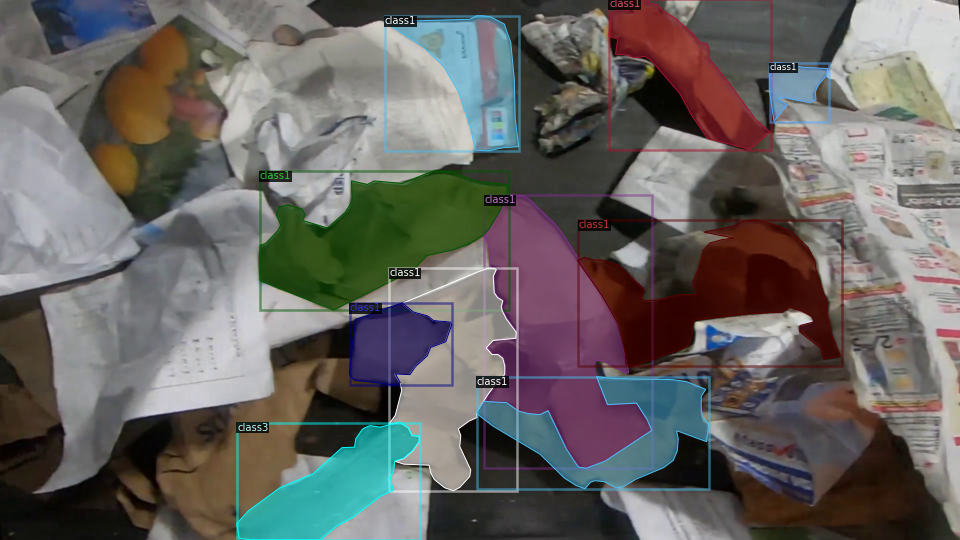

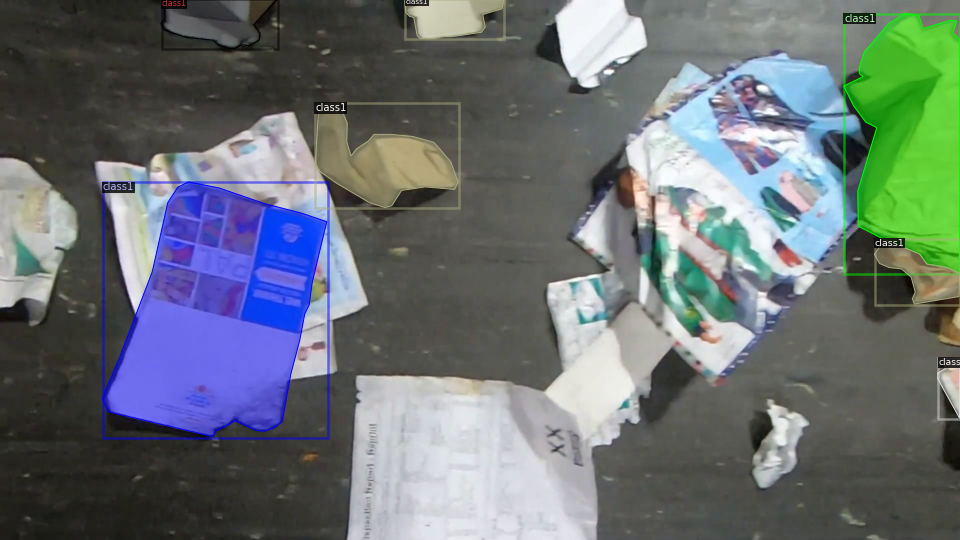

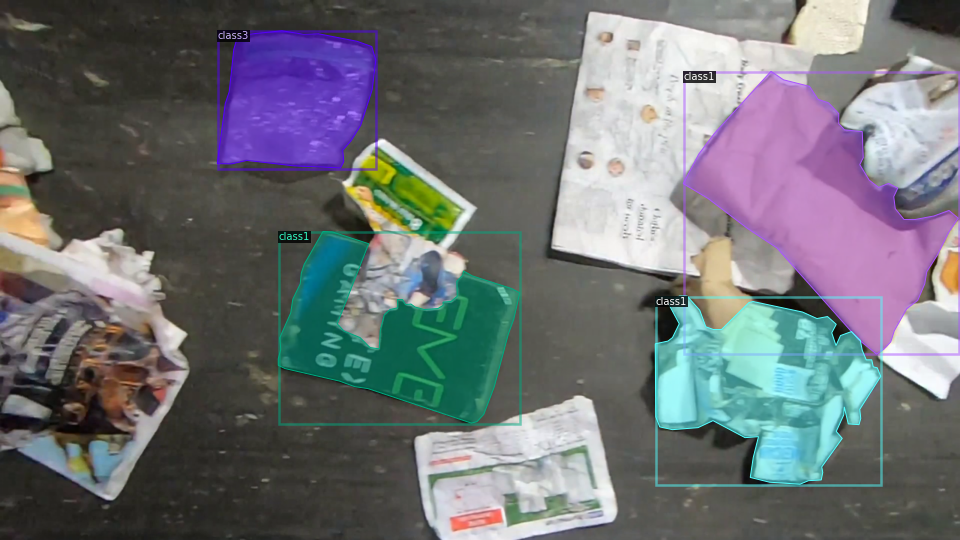

In [ ]:
dataset_dicts = get_zerowaste_dicts()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=zerowaste_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("zerowaste_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 4000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # we have 4 classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/03 23:35:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:13, 13.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[05/03 23:36:18 d2.engine.train_loop]: Starting training from iteration 0
[05/03 23:36:49 d2.utils.events]:  eta: 1:43:36  iter: 19  total_loss: 3.011  loss_cls: 1.384  loss_box_reg: 0.829  loss_mask: 0.687  loss_rpn_cls: 0.110  loss_rpn_loc: 0.034  time: 1.5614  data_time: 0.0315  lr: 0.000200  max_mem: 2672M
[05/03 23:37:21 d2.utils.events]:  eta: 1:43:12  iter: 39  total_loss: 2.352  loss_cls: 0.798  loss_box_reg: 0.828  loss_mask: 0.620  loss_rpn_cls: 0.086  loss_rpn_loc: 0.038  time: 1.5722  data_time: 0.0079  lr: 0.000400  max_mem: 2672M
[05/03 23:37:53 d2.utils.events]:  eta: 1:43:40  iter: 59  total_loss: 2.059  loss_cls: 0.672  loss_box_reg: 0.844  loss_mask: 0.469  loss_rpn_cls: 0.045  loss_rpn_loc: 0.034  time: 1.5799  data_time: 0.0078  lr: 0.000599  max_mem: 2672M
[05/03 23:38:25 d2.utils.events]:  eta: 1:44:10  iter: 79  total_loss: 1.805  loss_cls: 0.599  loss_box_reg: 0.790  loss_mask: 0.380  loss_rpn_cls: 0.061  loss_rpn_loc: 0.028  time: 1.5962  data_time: 0.0120  lr:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
cfg.DATASETS.TEST = ("zerowaste_train", )
predictor = DefaultPredictor(cfg)

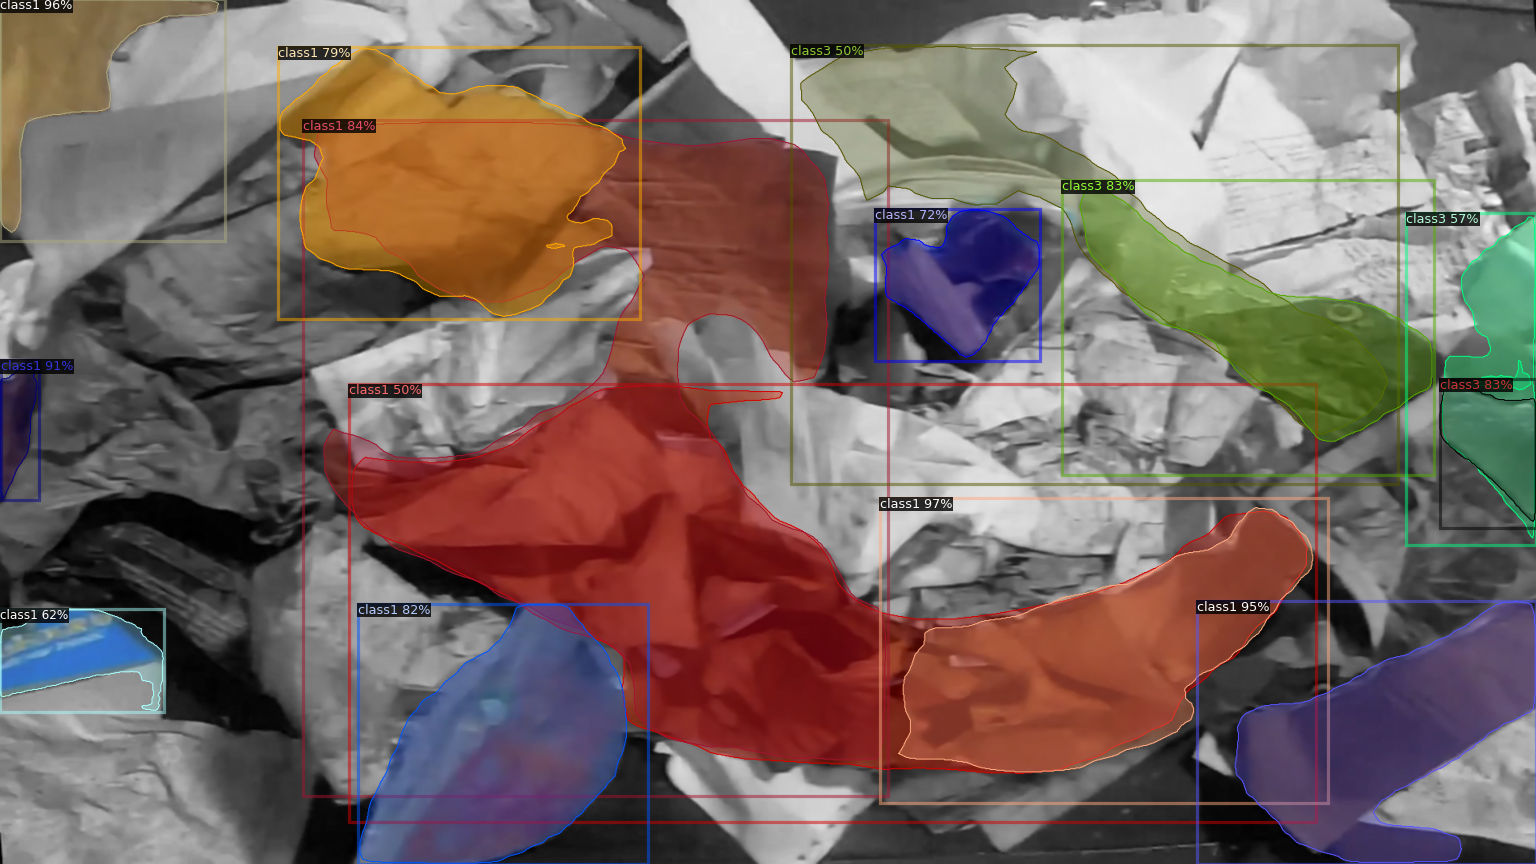

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_zerowaste_dicts()
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                    metadata=zerowaste_metadata, 
                    scale=0.8, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("zerowaste_train", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "zerowaste_train")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [05/04 01:25:10 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'zerowaste_train'. Trying to convert it to COCO format ...
[05/04 01:25:10 d2.data.datasets.coco]: Converting annotations of dataset 'zerowaste_train' to COCO format ...)
[05/04 01:25:10 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/04 01:25:13 d2.data.datasets.coco]: Conversion finished, #images: 3002, #annotations: 18002
[05/04 01:25:13 d2.data.datasets.coco]: Caching COCO format annotations at './output/zerowaste_train_coco_format.json' ...
[05/04 01:25:15 d2.data.common]: Serializing 3002 elements to byte tensors and concatenating them all ...
[05/04 01:25:16 d2.data.common]: Serialized dataset takes 9.25 MiB
[05/04 01:25:16 d2.evaluation.evaluator]: Start inference on 3002 images
[05/04 01:25:27 d2.evaluation.evaluator]: Inference done 11/3002. 0.5162 s / img. ETA=0:51:36
[05/04 01:25:33 d2.evaluation.evaluator]: Inference done 17/3002. 0.5046 s / img. ETA

OrderedDict([('bbox',
              {'AP': 30.801419811538942,
               'AP-class0': 20.037353870769987,
               'AP-class1': 36.50162363478438,
               'AP-class2': 38.84983338701926,
               'AP-class3': 27.81686835358215,
               'AP50': 49.490127291209355,
               'AP75': 34.185179715678615,
               'APl': 34.56952949915413,
               'APm': 19.32331235967194,
               'APs': 9.788408968137583}),
             ('segm',
              {'AP': 33.1567991393476,
               'AP-class0': 23.489634869042536,
               'AP-class1': 37.45574492552476,
               'AP-class2': 41.90278895114785,
               'AP-class3': 29.779027811675252,
               'AP50': 49.24415663465938,
               'AP75': 36.67154798946938,
               'APl': 37.92704339096241,
               'APm': 14.698710094991874,
               'APs': 6.081760691497998})])

In [6]:
import json
def json2dict(path):
    with open(path) as f:
        return json.load(f)
labels_test = json2dict("./splits_final_deblurred/test/labels.json")

img_all = labels_test["images"]
anno_raw = labels_test["annotations"]
anno_all = [list() for idx in range(3002)]

for idx in range(len(anno_raw)):
    tmp = anno_raw[idx]
    idx_img = tmp["image_id"]
    anno_all[idx_img].append(tmp)

In [7]:
def get_zerowaste_dicts():
    dataset_dicts = []
    for idx0 in range(len(img_all)):
        record = dict()
        tmp = img_all[idx0]
        record["file_name"] = os.path.join("./splits_final_deblurred/test/data", tmp["file_name"])
        record["image_id"] = tmp["id"]
        record["width"] = tmp["width"]
        record["height"] = tmp["height"]
        
        tmp_tmp = anno_all[idx0]
        objs = list()
        for item in tmp_tmp:
            obj = dict()
            obj["bbox"] = item["bbox"]
            obj["bbox_mode"] = BoxMode.XYWH_ABS
            obj["segmentation"] = item["segmentation"]
            obj["category_id"] = item["category_id"] - 1
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.clear()
DatasetCatalog.register("zerowaste_test", get_zerowaste_dicts)
MetadataCatalog.get("zerowaste_test").set(thing_classes=["class0", "class1", "class2", "class3"])
zerowaste_metadata = MetadataCatalog.get("zerowaste_test")

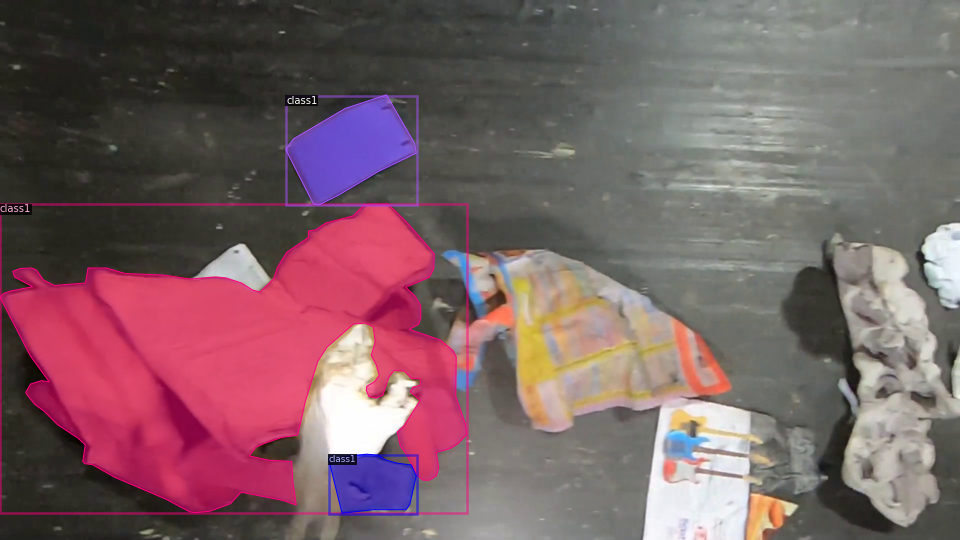

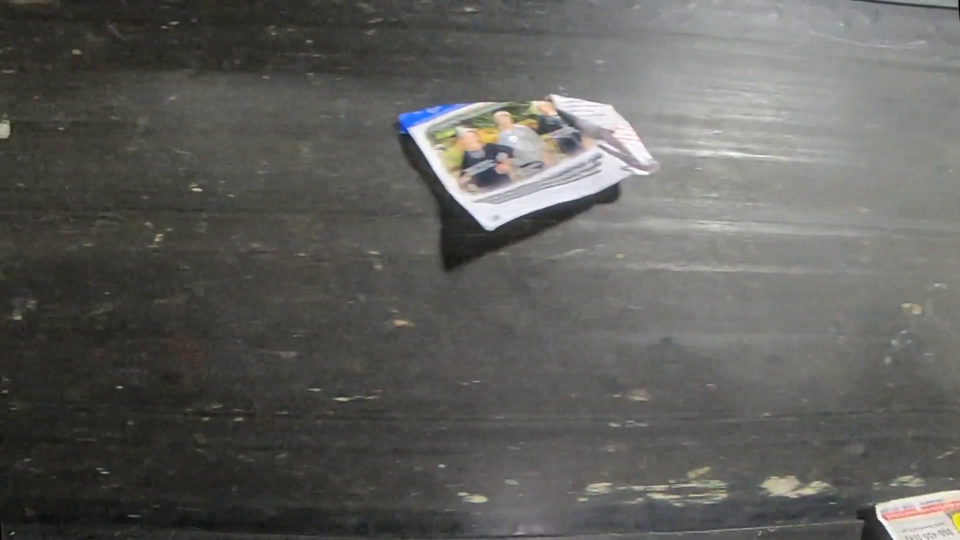

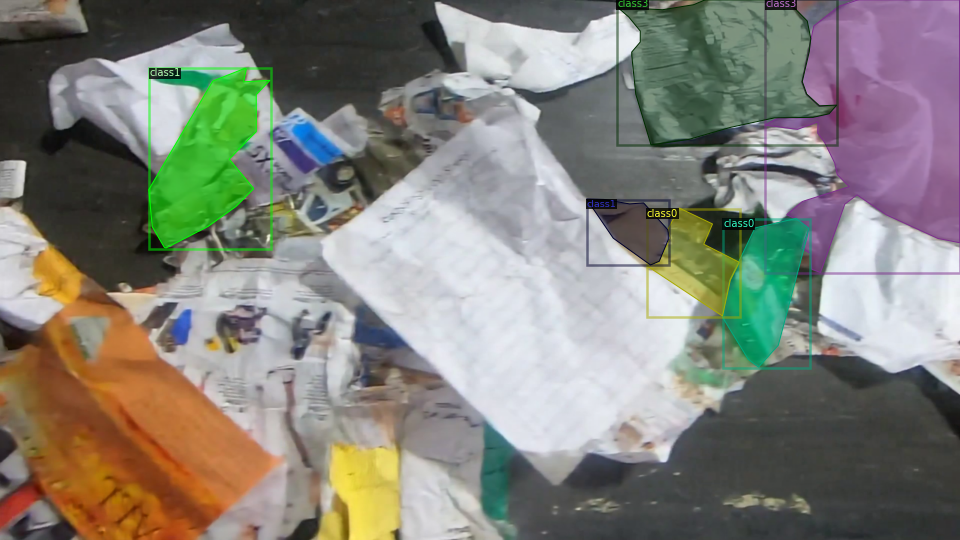

In [8]:
dataset_dicts = get_zerowaste_dicts()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=zerowaste_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("zerowaste_test",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 4000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # we have 4 classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("zerowaste_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "zerowaste_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [05/04 04:08:01 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'zerowaste_test'. Trying to convert it to COCO format ...
[05/04 04:08:01 d2.data.datasets.coco]: Converting annotations of dataset 'zerowaste_test' to COCO format ...)
[05/04 04:08:01 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/04 04:08:02 d2.data.datasets.coco]: Conversion finished, #images: 929, #annotations: 5077
[05/04 04:08:02 d2.data.datasets.coco]: Caching COCO format annotations at './output/zerowaste_test_coco_format.json' ...
[05/04 04:08:03 d2.data.common]: Serializing 929 elements to byte tensors and concatenating them all ...
[05/04 04:08:03 d2.data.common]: Serialized dataset takes 2.74 MiB
[05/04 04:08:03 d2.evaluation.evaluator]: Start inference on 929 images
[05/04 04:08:07 d2.evaluation.evaluator]: Inference done 11/929. 0.0942 s / img. ETA=0:05:20
[05/04 04:08:13 d2.evaluation.evaluator]: Inference done 23/929. 0.1016 s / img. ETA=0:06:08


OrderedDict([('bbox',
              {'AP': 21.376887940659177,
               'AP-class0': 29.28640345043856,
               'AP-class1': 32.225336385997174,
               'AP-class2': 2.7343082338766624,
               'AP-class3': 21.26150369232431,
               'AP50': 34.5356991170334,
               'AP75': 22.573552223368893,
               'APl': 22.336297339528116,
               'APm': 15.950832638831614,
               'APs': 8.916572285544202}),
             ('segm',
              {'AP': 22.159937806172657,
               'AP-class0': 30.12533502149404,
               'AP-class1': 34.29864776786026,
               'AP-class2': 2.030798604036189,
               'AP-class3': 22.184969831300137,
               'AP50': 34.61027971811287,
               'AP75': 23.86704122024618,
               'APl': 23.472279113640422,
               'APm': 10.610483913199085,
               'APs': 2.5838997519048497})])